# Lets see if we can determine what optimal parameters to chose

In [1]:
import os 
import json
import pandas as pd
import numpy as np
import velopix_tracking as velopix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
import pandas as pd

def merge(results):
    """
    Given a list of JSON result dictionaries from multiple runs,
    return two DataFrames:
      - overall_df: one row per run with overall metrics and parameters.
      - category_df: one row per category per run, also including parameters.
    """
    overall_rows = []
    category_rows = []
    
    for run_id, res in enumerate(results):
        # Extract solver parameters if available.
        params = res.get('parameters', {})
        overall_row = {
            'run_id': run_id,
            'total_tracks': res.get('total_tracks'),
            'total_ghosts': res.get('total_ghosts'),
            'overall_ghost_rate': res.get('overall_ghost_rate'),
            'event_avg_ghost_rate': res.get('event_avg_ghost_rate')
        }
        # Merge parameters into the overall summary.
        overall_row.update(params)
        overall_rows.append(overall_row)
        
        # Process each category: add run_id and merge parameters.
        for cat in res.get('categories', []):
            cat_row = cat.copy()
            cat_row['run_id'] = run_id
            cat_row.update(params)
            category_rows.append(cat_row)
    
    overall_df = pd.DataFrame(overall_rows)
    category_df = pd.DataFrame(category_rows)
    
    return overall_df, category_df


### Lets load all the data

In [3]:
events = []
json_events = []
n_files = 100

for i in range(0, n_files):
    if i == 51:
        """
        There's an issue with event 51 -> module_prefix_sum contains value 79 twice resulting in and indexing error when loading the event
        """
        print(f"Skipping problematic file: velo_event_{i}.json")
    else:    
        print(f"Loading file: velo_event_{i}.json")
        event_file = open(os.path.join("../DB", f"velo_event_{i}.json"))
        json_data = json.loads(event_file.read())
        events.append(velopix.Event(json_data))
        json_events.append(json_data)
        event_file.close()

Loading file: velo_event_0.json
Loading file: velo_event_1.json
Loading file: velo_event_2.json
Loading file: velo_event_3.json
Loading file: velo_event_4.json
Loading file: velo_event_5.json
Loading file: velo_event_6.json
Loading file: velo_event_7.json
Loading file: velo_event_8.json
Loading file: velo_event_9.json
Loading file: velo_event_10.json
Loading file: velo_event_11.json
Loading file: velo_event_12.json
Loading file: velo_event_13.json
Loading file: velo_event_14.json
Loading file: velo_event_15.json
Loading file: velo_event_16.json
Loading file: velo_event_17.json
Loading file: velo_event_18.json
Loading file: velo_event_19.json
Loading file: velo_event_20.json
Loading file: velo_event_21.json
Loading file: velo_event_22.json
Loading file: velo_event_23.json
Loading file: velo_event_24.json
Loading file: velo_event_25.json
Loading file: velo_event_26.json
Loading file: velo_event_27.json
Loading file: velo_event_28.json
Loading file: velo_event_29.json
Loading file: velo_e

In [4]:
# Define parameter ranges and number of random samples
low, high = 0.1, 1.0
n_samples = 100 # est 8s for 100 events -> 100 * 8 = 800s / 60s = 13.34min

# Randomly sample parameter values for [max_slope, max_tolerance, scatter]
param_samples = np.random.uniform(low=low, high=high, size=(n_samples, 3))

# Container for evaluation results
eval_results = []

# Evaluate the algorithm for each random parameter combination
for params in param_samples:
    slope, tol, scat = params
    # Initialize solver with current parameters (assumed to take tuples for slopes and tolerances)
    solver = velopix.TrackFollowing((slope, slope), (tol, tol), scat)
    tracks = solver.solve_parallel(events=events)
    result = velopix.validate_to_json(json_events, tracks)
    result["parameters"] = {
        "max_slopes": (slope, slope),
        "max_tolerance": (tol, tol),
        "scatter": scat
    }
    eval_results.append(result)

Instantiating track_following solver with parameters
 max slopes: (0.8526775242522434, 0.8526775242522434)
 max tolerance: (0.35315947156316063, 0.35315947156316063)
 max scatter: 0.26076334412714663

update_efficiencies: No particles match condition for 'long_strange>5GeV'
update_efficiencies: No particles match condition for 'long_strange'
update_efficiencies: No particles match condition for 'long_strange>5GeV'
update_efficiencies: No particles match condition for 'long_strange'
update_efficiencies: No particles match condition for 'long_strange>5GeV'
update_efficiencies: No particles match condition for 'long_strange>5GeV'
update_efficiencies: No particles match condition for 'long_strange>5GeV'
update_efficiencies: No particles match condition for 'long_strange>5GeV'
update_efficiencies: No particles match condition for 'long_strange'
update_efficiencies: No particles match condition for 'long_strange>5GeV'
update_efficiencies: No particles match condition for 'long_strange>5GeV'


In [5]:
# Convert results into a DataFrame
data_df = pd.DataFrame(eval_results)
# Extract scalar parameter values
data_df['max_slope_val'] = data_df['parameters'].apply(lambda x: x["max_slopes"][0])
data_df['max_tol_val'] = data_df['parameters'].apply(lambda x: x["max_tolerance"][0])
data_df['scatter_val']  = data_df['parameters'].apply(lambda x: x["scatter"])

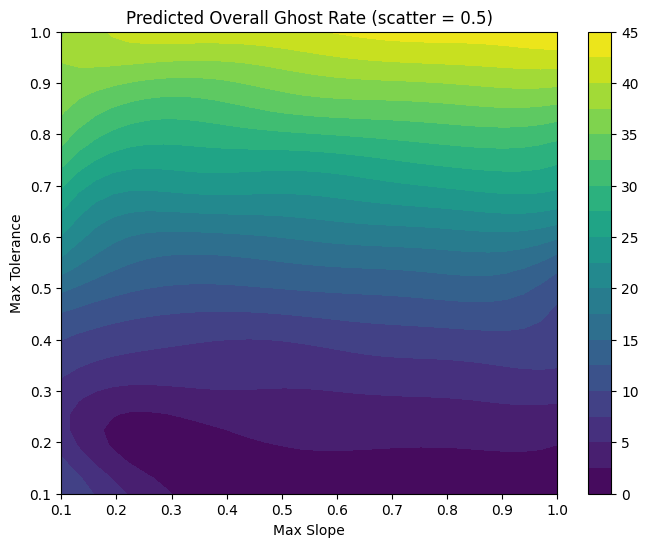

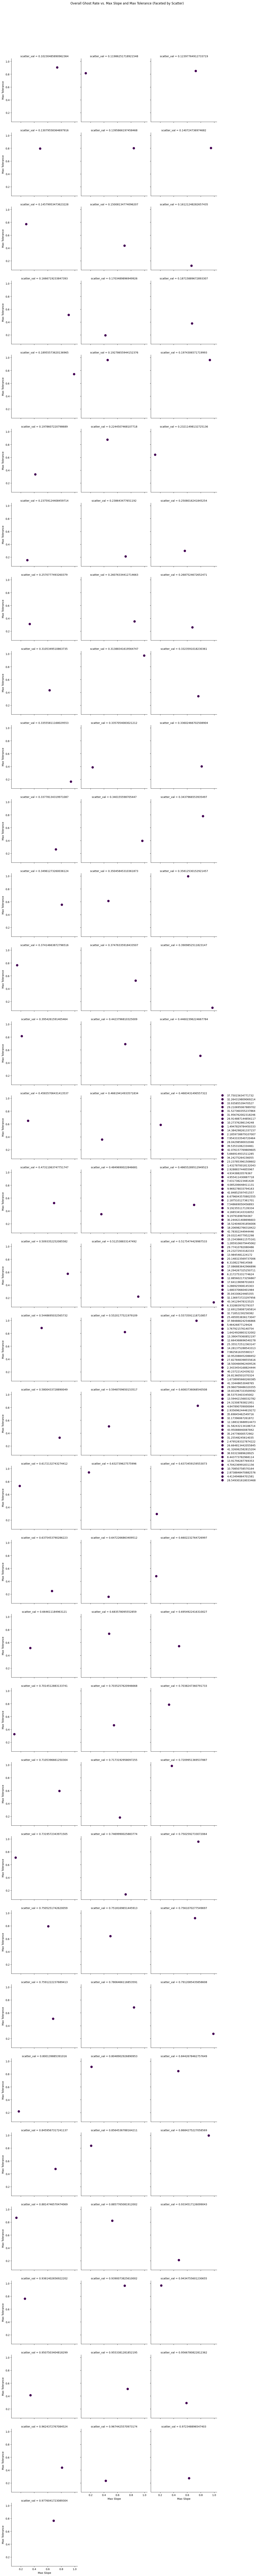

In [ ]:
# Assume overall_ghost_rate is the performance metric of interest
# Prepare data for surrogate modeling
X = data_df[['max_slope_val', 'max_tol_val', 'scatter_val']].values
y = data_df['overall_ghost_rate'].values

# Create and train a Gaussian Process Regressor as the surrogate model
kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0, 1.0], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, y)

# Visualization: Fix scatter to a chosen value and explore max_slope and max_tol
scatter_fixed = 0.5  # Fix scatter value (you can iterate over several fixed values)
grid_size = 30
slope_lin = np.linspace(low, high, grid_size)
tol_lin = np.linspace(low, high, grid_size)
S, T = np.meshgrid(slope_lin, tol_lin)
# Create input for prediction (fixed scatter value)
X_pred = np.column_stack([S.ravel(), T.ravel(), np.full(S.size, scatter_fixed)])
y_pred, sigma = gp.predict(X_pred, return_std=True)
Y_pred = y_pred.reshape(S.shape)

# Create a contour plot of the predicted performance
plt.figure(figsize=(8, 6))
cp = plt.contourf(S, T, Y_pred, levels=20, cmap='viridis')
plt.colorbar(cp)
plt.xlabel('Max Slope')
plt.ylabel('Max Tolerance')
plt.title(f'Predicted Overall Ghost Rate (scatter = {scatter_fixed})')
plt.show()

/var/folders/cz/r9zhzycs23b9pwh_wffb3kt80000gn/T/ipykernel_68124/2580827122.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


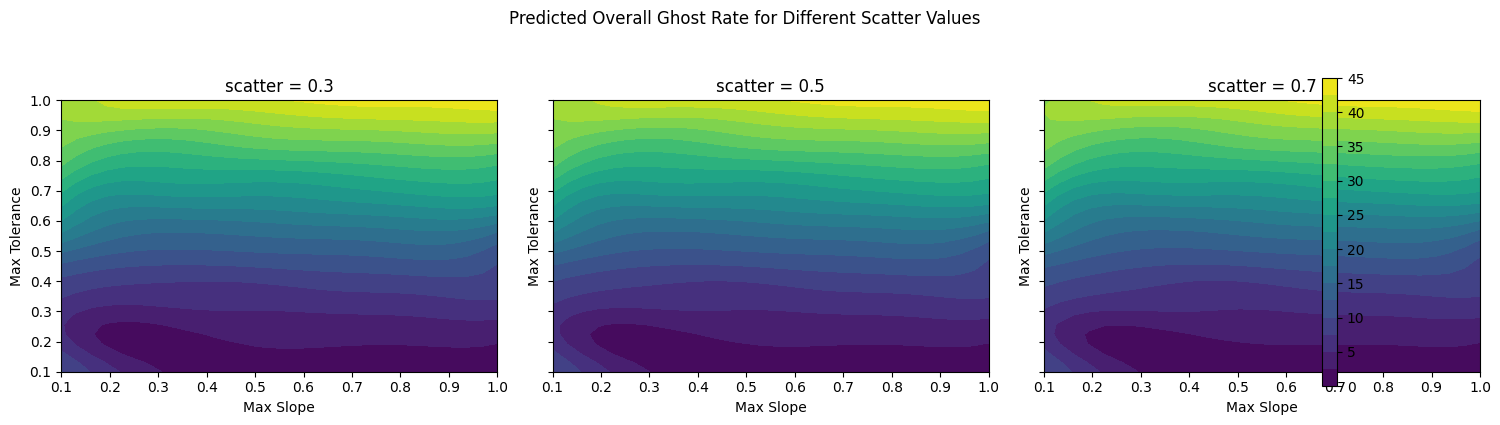

In [12]:
import matplotlib.pyplot as plt

scatter_values = [0.3, 0.5, 0.7]  # Choose a few representative scatter values
fig, axes = plt.subplots(1, len(scatter_values), figsize=(5 * len(scatter_values), 4), sharex=True, sharey=True)

for ax, scat in zip(axes, scatter_values):
    # Create grid for max_slope and max_tol
    grid_size = 30
    slope_lin = np.linspace(0.1, 1.0, grid_size)
    tol_lin = np.linspace(0.1, 1.0, grid_size)
    S, T = np.meshgrid(slope_lin, tol_lin)
    
    # Prepare input for prediction
    X_pred = np.column_stack([S.ravel(), T.ravel(), np.full(S.size, scat)])
    y_pred, sigma = gp.predict(X_pred, return_std=True)
    Y_pred = y_pred.reshape(S.shape)
    
    # Plot contour
    cp = ax.contourf(S, T, Y_pred, levels=20, cmap='viridis')
    ax.set_xlabel('Max Slope')
    ax.set_ylabel('Max Tolerance')
    ax.set_title(f'scatter = {scat}')

fig.suptitle('Predicted Overall Ghost Rate for Different Scatter Values', y=1.05)
fig.colorbar(cp, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()

